# CSAIL Data

In [11]:
push!(LOAD_PATH, "../src");
include("../src/pose.jl")

In [2]:
#nbx --fname="src/csail_data.jl"
import JSON
using MyUtils: polar_inv
SLAM_DATA_KEYS = ["z", "a", "x", "hd", "dx", "dhd"] 

"""
    d::Dict = load_sensor_data(fname)

Loads sensor data json. Assumes/requires that the json 
contains keys: `z`, `a`, `x`, `hd`, `dx`, and `dhd`.
"""
function load_sensor_data(fname)
    d′  = JSON.parsefile(fname)
    d = Dict()
    for k in SLAM_DATA_KEYS
        d[k] = [Float64.(x) for x in d′[k]]
    end
    return d
end


load_sensor_data

In [41]:
#nbx
fname = "../data/mit-csail.json"
d     = load_sensor_data(fname);

_zs   = d["z"]
_zmax = maximum(maximum.(_zs))

_zs_inf = d["z"]
for i=1:length(_zs)
    z = _zs[i]
    _zs_inf[i][z.==_zmax] .= Inf
end

_as     = d["a"]
_ys     = [polar_inv(z,_as) for z in _zs];
_ys_inf = [polar_inv(z,_as) for z in _zs_inf];

_xs    = d["x"]
_hds   = d["hd"]
_ps    = [Pose(x,hd) for (x,hd) in zip(_xs, _hds)]

_dxs   = d["dx"]
_dhds  = d["dhd"]
_us    = [Control(dx,dhd) for (dx,dhd) in zip(_dxs, _dhds)]

_T     = length(_zs)
_num_a = length(_as)

println("Loading `$(fname)` ...\n")
for x in [:_zs, :_zs_inf, :_as, :_zmax, :_ys, :_ys_inf, :_num_a, :_xs, :_hds, :_ps, :_dxs, :_dhds, :_us, :_T]
    local y = getproperty(Main,x)
    println("\t$(x) \t$(typeof(y))")
end

Loading `../data/mit-csail.json` ...

	_zs 	Vector{Vector{Float64}}
	_zs_inf 	Vector{Vector{Float64}}
	_as 	Vector{Float64}
	_zmax 	Float64
	_ys 	Vector{Vector{Vector{Float64}}}
	_ys_inf 	Vector{Vector{Vector{Float64}}}
	_num_a 	Int64
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


## Visualization

In [4]:
using BenchmarkTools;
using Colors, Plots;
using Interact
using MyUtils: rot
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));

WebIO._IJuliaInit()

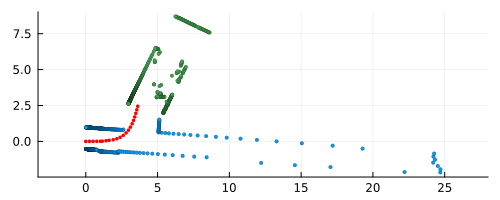

In [53]:
s  = 20
t1 = 1_050
t2 = t1+s

ps = [_ps[t1]]
for u in _us[t1:t2-1]
    p = ps[end] + u
    push!(ps, p)
end
ps = [p/_ps[t1] for p in ps]

# --------
plot(size=(500,200), legend=nothing, aspect_ratio=:equal)
scatter!([p.x for p in ps], c=:red, markersize=2, markerstrokewidth=0)
scatter!(_ys[t1].*ps[1], c=col[1], markersize=2, markerstrokewidth=0.5)
scatter!(_ys[t2].*ps[end], c=col[3], markersize=2, markerstrokewidth=0.5)

In [ ]:

s  = 10
t1 = 1_100
t2 = t1+s

# --------------------
mypl = plot(size=(600,600), aspect_ratio=:equal, grid=false, showaxis = false,
                ylim=(-10,15), 
                xlim=(-20,20), 
                legend=nothing)


s′  = 30
t1′ = t1 - s′
t2′ = t1′+ s′ - 1
ps  = [_ps[t1′]]
ys  = [_ys[t1′]]

for (i,t′) in enumerate(t1′:t2′-1)
    u = _us[t′]
    p = ps[end] + u
    push!(ps, p)
    push!(ys, _ys[t′])
end
ps = [p/_ps[t2′]*Pose(0,0,π/2) for p in ps]

for (i,(p,y)) in enumerate(zip(ps, ys))
    scatter!(y .* p , markerstrokewidth=0, c=cgrad(:binary)[i/s′/20], markersize=1)
end

y = _ys_inf[t1] .* Pose(0,0,π/2)

c = :lightblue
plot!([[0, y1] for (y1,y2) in y[1:5:end]], [[0, y2] for (y1,y2) in y[1:5:end]], 
    legend=nothing, alpha=.2, c=c)

c = col[1]
scatter!(y, markerstrokewidth=0, markerstrokecolor=c, c=c, markersize=1)
c = col[1]
scatter!([0],[0.2], c=c, marker=:^, markersize=4, markerstrokewidth=0,)
# scatter!([0],[1], c=c, marker=:x)
mypl

In [ ]:
ani = Animation()

s  = 300
t1 = 1_070
t2 = t1+s

for t=t1:t2
    # --------------------
    mypl = plot(size=(600,600), dpi=150, aspect_ratio=:equal, grid=false, showaxis = false,
                ylim=(-20,20), 
                xlim=(-5,35), 
                legend=nothing)


    s′  = 120
    t1′ = max(t - s′, t1)
    t2′ = min(t1′+ s′ - 1,t)

    for (i,t′) in enumerate(t1′:t2′)
        p = _ps[t′]/_ps[t1] * Pose(0,0,π/2)
        y = _ys_inf[t′] .* p
        c = cgrad(:binary)[i/s′/4]
        scatter!(y, markerstrokewidth=0, markerstrokecolor=c, c=c, markersize=1)
    end

    p = _ps[t]/_ps[t1] * Pose(0,0,π/2)
    y = _ys_inf[t] .* p 

    c = :lightblue
    plot!([[p.x[1], y1] for (y1,y2) in y[1:5:end]], [[p.x[2], y2] for (y1,y2) in y[1:5:end]], 
        legend=nothing, alpha=.2, c=c)

    
    c = col[1]
    scatter!(y, markerstrokewidth=0, markerstrokecolor=c, c=c, markersize=2)
    c = :red
    scatter!([p.x], c=c, marker=:o, markersize=4, markerstrokewidth=0, markerstrokecolor=c)
    scatter!([p.x + unit_vec(p.hd)], c=c, marker=:o, markersize=2, markerstrokewidth=0, markerstrokecolor=c)
    frame(ani, mypl)
end
FPS = 10
gif(ani, "_imgs/csail_data_FPS$(FPS).gif", fps=FPS) # gif(ani, fname, fps=10)

In [ ]:
@manipulate for t=slider(1:2:_T, value=1_040, label="t")
    plot(size=(600,400), aspect_ratio=:equal, ylim=(-2,20), xlim=(-20,20), legend=nothing)
    y = [rot(π/2)] .* _ys[t]

    plot!([[0, y1] for (y1,y2) in y[1:5:end]], [[0, y2] for (y1,y2) in y[1:5:end]], 
        legend=nothing, alpha=.4, c=:lightgray)

    scatter!(y, markerstrokewidth=0, c=col[1], markersize=2)
    scatter!([0],[0], c=:red, marker=:o, markersize=5, markerstrokewidth=0,)
    scatter!([0],[1], c=:red, marker=:x)
end

In [ ]:
ani = Animation()

t1    = 1_050
steps = 10
t2    = t1+steps

for t=t1:t2
    mypl = plot(size=(700,500), aspect_ratio=:equal, grid=false, showaxis = false,
                ylim=(-5,20), xlim=(-20,20), legend=nothing)

    p = _ps[t1]
    for s = 0:9
        p = p + _us[t1+s]
        y = _ys_inf[t] .* Pose(0,0,π/2)/p
        scatter!(y, markerstrokewidth=0, c=col[1], markersize=2)
    end


    y = _ys_inf[t] .* Pose(0,0,π/2)

    plot!([[0, y1] for (y1,y2) in y[1:5:end]], [[0, y2] for (y1,y2) in y[1:5:end]], 
        legend=nothing, alpha=.4, c=:lightgray)

    scatter!(y, markerstrokewidth=0, c=col[1], markersize=2)
    scatter!([0],[0], c=:red, marker=:o, markersize=5, markerstrokewidth=0,)
    scatter!([0],[1], c=:red, marker=:x)
    frame(ani, mypl)
end
gif(ani, "_imgs/csail_data.gif", fps=10) # gif(ani, fname, fps=10)